# TMDB Box Office Predictions 
In this project, we will use supervised machine learning models to predict the box office revenue of hundreds of films. The film industry is a multi-billion-dollar business, and offers an immense amount of data about movies, all available through the internet. 

In this project, we will use supervised machine learning techniques to predict the box office revenue of hundreds of films. This research could be used to help investors in the business avoid risks. The models predict an approximate success rate of a movie based on its features by analyzing data from The Movie Data Base.

Source: https://www.kaggle.com/c/tmdb-box-office-prediction/data?select=train.csv

In [1]:
#import dependencies 
import pandas as pd
import numpy as np
import json
from collections import Counter
from pprint import pprint
import requests
import os 
import csv 
from datetime import datetime
from xgboost import XGBRegressor
from config import api_key

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Remerging the data
We were not happy with the way the dataset was already split into training and testing frames, so we decided to remerge them in order to conduct our own split. However, the test.csv did not have a revenue column. To fix this issue we created an API pull to obtain all of the films' in the test data revenue.

In [3]:
#make all columns visible
pd.set_option('display.max_columns', None)

In [5]:
#Import Datasets from Kaggle
train_data = pd.read_csv('Resources/Merged_Frames.csv')

In [6]:
train_data

,Unnamed: 0,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8014,5014,7394,NaN,42000000,"[{'id': 53, 'name': 'Thriller'}]",NaN,tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,9.970359,/i8FEQy5IWAqOzXm4uDHy2r3Swym.jpg,"[{'name': 'Intermedia Films', 'id': 763}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/3/01,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,This is not a love story - it's a story about ...,Original Sin,"[{'id': 515, 'name': 'women'}, {'id': 572, 'na...","[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de...",35402320
8015,5015,7395,"[{'id': 146534, 'name': 'Without a Paddle Coll...",19000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0364751,en,Without a Paddle,"Three friends, whose lives h

In [7]:
#check to see how many missing values each potential feature has
train_data.isna().sum().sort_values(ascending=False)

belongs_to_collection    6371
homepage                 5412
tagline                  1544
Keywords                  700
production_companies      415
production_countries      155
spoken_languages           57
crew                       38
cast                       26
overview                   26
genres                     21
runtime                     4
poster_path                 2
status                      2
release_date                1
title                       0
Unnamed: 0                  0
id                          0
popularity                  0
original_title              0
original_language           0
imdb_id                     0
budget                      0
revenue                     0
dtype: int64

# Data Cleaning
The variables in these datasets are classifying to two main type of data, character/text and numeric/integer.
Based on the missing values, it definitly looks like we are going to need to drop the following features:
belongs_to_collection
homepage
tagline
Keywords

In [8]:
#We will drop the columns that we do not believe will aid our models 
train_data= train_data.drop(columns=['belongs_to_collection','homepage','tagline','Keywords'])

In [9]:
#because we remerged and now have a larger dataset, we can afford to drop remaining missing values
train_data.dropna(inplace=True)

# Pre-processing 
- Dealing with poor formatting and any categorical variables before running our models

The character/text variables (belongs to collection, genres, crew, cast, etc) all possess a complicated text structure ([{‘id’: 35, ‘name’: ‘Comedy’}]) To fix this issue we must  remove all unnecessary characters, extracting only the required data for analysis.

The numeric variables are budget, revenue, popularity, runtime. There are quite a few of them that have "0"s, since we know it is unlikey that a film has NO budget, revenue, or runtime, we will replace these values with the mean of each respected category.

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7501 entries, 0 to 8018
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            7501 non-null   int64  
 1   id                    7501 non-null   int64  
 2   budget                7501 non-null   int64  
 3   genres                7501 non-null   object 
 4   imdb_id               7501 non-null   object 
 5   original_language     7501 non-null   object 
 6   original_title        7501 non-null   object 
 7   overview              7501 non-null   object 
 8   popularity            7501 non-null   float64
 9   poster_path           7501 non-null   object 
 10  production_companies  7501 non-null   object 
 11  production_countries  7501 non-null   object 
 12  release_date          7501 non-null   object 
 13  runtime               7501 non-null   float64
 14  spoken_languages      7501 non-null   object 
 15  status               

In [11]:
#check budget feature
print(len(train_data[train_data['budget']==0]))

1849


In [12]:
#check revenue
print(len(train_data[train_data['revenue']==0]))

62


In [13]:
#looking at the dataframe, we can see that while no budget values are null, there are A LOT that are equal to 0
#to fix this issue:
budget_mean = train_data.loc[train_data['budget'] > 0, 'budget'].mean()
train_data["budget"] = train_data["budget"].mask(train_data["budget"] == 0, budget_mean)

In [14]:
#Perform the same thing for revenue

In [15]:
revenue_median = train_data.loc[train_data['revenue'] > 0, 'revenue'].median()
train_data["revenue"] = train_data["revenue"].mask(train_data["revenue"] == 0, revenue_median)

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revenue', ylabel='Density'>

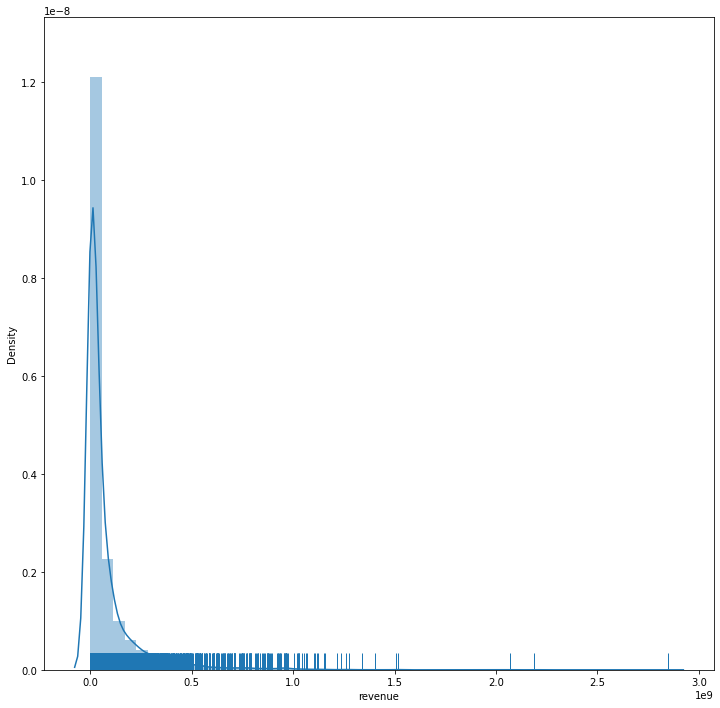

In [16]:
#view the revenue in a distplot (used to depict the distplot with different variations in it.)
plt.figure(figsize=(12,12))
sns.distplot(train_data['revenue'],rug=True)

In [17]:
#Return on investment (ROI) is a ratio between net profit and cost of investment. 
#A high ROI means the investment’s gains compare favorably to its cost. 
#As a performance measure, ROI is used to evaluate the efficiency of an investment or to compare the 
#efficiencies of several different investments.
roi_rev= train_data['revenue']
roi_budget= train_data['budget']
avg_profit_ratio =sum(roi_rev)/sum(roi_budget)
avg_profit_ratio

2.3680983757579948

In average, the profit ratio of a movie was 237%

In [18]:
correlation_df= train_data.copy()

In [19]:
correlation_df

,Unnamed: 0,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,title,cast,crew,revenue
0,0,1,1.400000e+07,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651.0
1,1,2,4.000000e+07,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435.0
2,2,3,3.300000e+06,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000.0
6,6,7,1.400000e+07,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,/4QjzFuaZmB4btGnLwAgdp23BzIU.jpg,"[{'name': 'Ghost House Pictures', 'id': 768}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Possession,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075.0
8,8,9,3.216656e+07,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,/5A8gKzOrF9Z7tSUX6xd5dEx4NXf.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/16/96,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Muppet Treasure Island,"[{'cast_id': 1, 'character': 'Long John Silver...","[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8014,5014,7394,4.200000e+07,"[{'id': 53, 'name': 'Thriller'}]",tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,9.970359,/i8FEQy5IWAqOzXm4uDHy2r3Swym.jpg,"[{'name': 'Intermedia Films', 'id': 763}, {'na...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",8/3/01,118.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Original Sin,"[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de...",35402320.0
8015,5015,7395,1.900000e+07,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0364751,en,Without a Paddle,"Three friends, whose lives have been drifting ...",6.046516,/oZDbFtTnTwW5GSfyaGFGaYxDBgD.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/20/04,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Without a Paddle,"[{'cast_id': 40, 'character': 'Dan Mott', 'cre...","[{'credit_id': '52fe43b29251416c7501a909', 'de...",69631118.0
8016,5016,7396,1.600000e+07,"[{'id': 18, 'name': 'Drama'}]",tt0084855,en,The Verdict,"Frank Galvin is a down-on-his luck lawyer, red...",9.596883,/hh9sIE1PT7Pjq3n2fzHNEHh8Ogq.jpg,[{'name': 'Twentieth Century Fox Film Corporat

In [20]:
correlation_df= correlation_df.drop(columns=['id','genres','imdb_id','original_language','original_title',
                                             'overview','poster_path','production_companies','production_countries',
                                             'release_date','spoken_languages','status','title','cast','crew'])

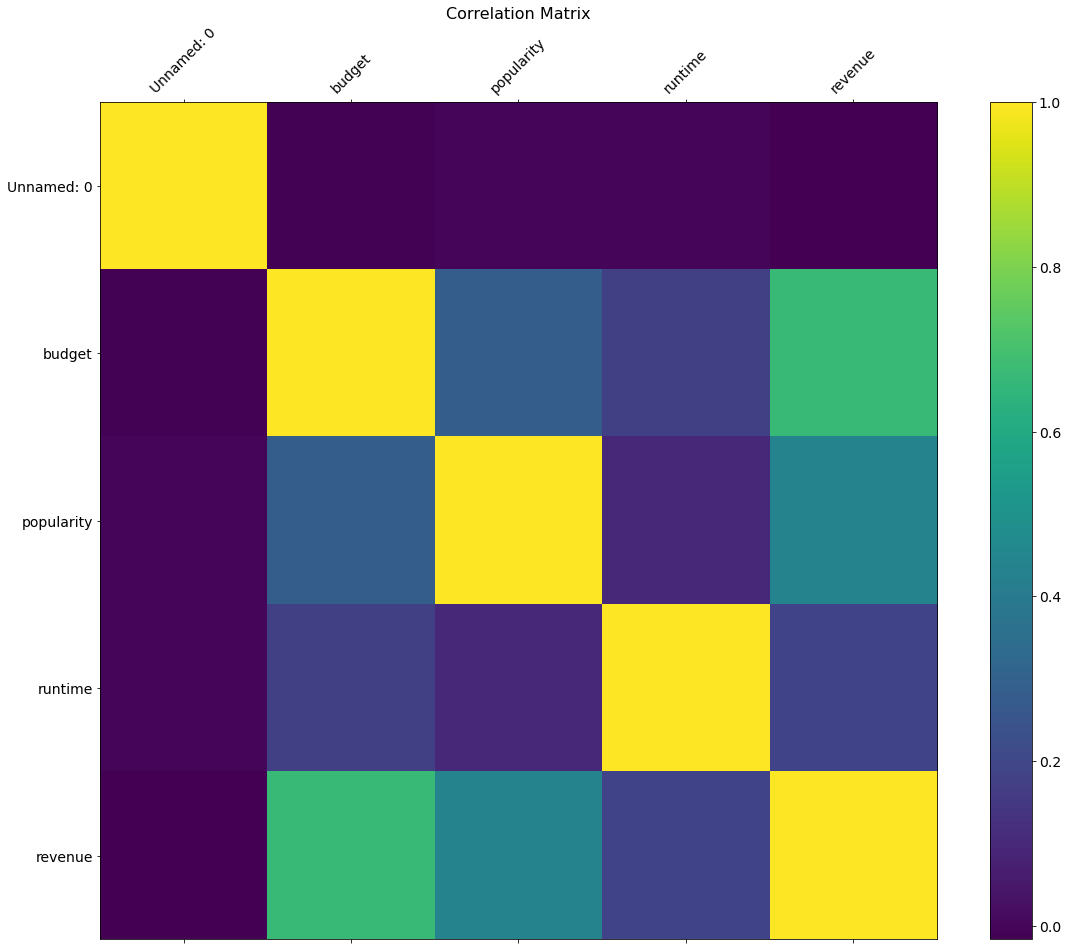

In [21]:
f = plt.figure(figsize=(19, 15))
plt.matshow(correlation_df.corr(), fignum=f.number)
plt.xticks(range(correlation_df.select_dtypes(['number']).shape[1]), correlation_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(correlation_df.select_dtypes(['number']).shape[1]), correlation_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [22]:
corr = correlation_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Unnamed: 0,budget,popularity,runtime,revenue
Unnamed: 0,1.000000,-0.008654,0.002445,-0.003033,-0.016212
budget,-0.008654,1.000000,0.282554,0.175155,0.671969
popularity,0.002445,0.282554,1.000000,0.096011,0.439110
runtime,-0.003033,0.175155,0.096011,1.000000,0.186862
revenue,-0.016212,0.671969,0.439110,0.186862,1.000000


as expected, budget and revenue are the highest correlated at 0.67

In [23]:
#attempt to evenly distribute revenue data with log
train_data['logrevenue'] = np.log1p(train_data['revenue'])

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='logrevenue', ylabel='Density'>

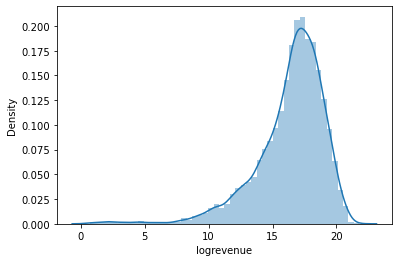

In [24]:
sns.distplot(train_data['logrevenue'])

In [25]:
#Lets look at some plots to see how some of the data is distributed and correlated 

<AxesSubplot:xlabel='revenue', ylabel='budget'>

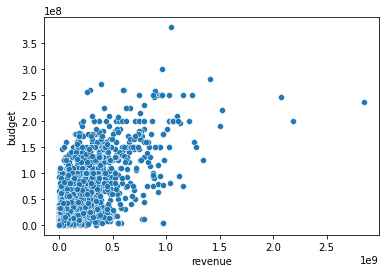

In [26]:
sns.scatterplot(x='revenue',y='budget',data=train_data)

<AxesSubplot:xlabel='revenue', ylabel='popularity'>

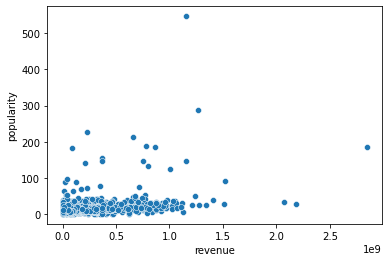

In [27]:
sns.scatterplot(x='revenue',y='popularity',data=train_data)

<AxesSubplot:xlabel='count', ylabel='original_language'>

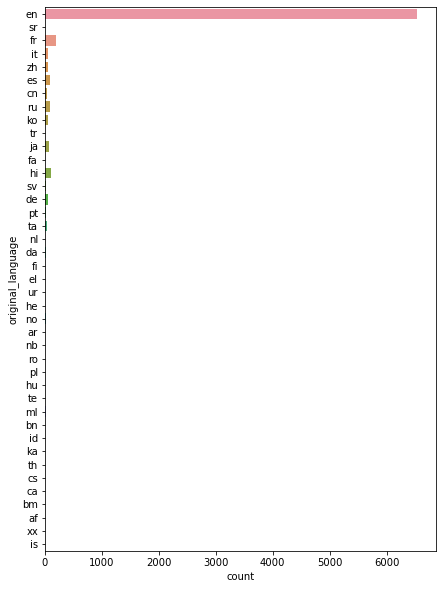

In [28]:
#we assume that en will be the highest in original language, but we can view it to get a better idead of the distribution
plt.figure(figsize=(7,10))
sns.countplot(y='original_language',data=train_data)

# JSON Parsing

In [29]:
#fixing genre, production company, production country, etc 

In [30]:
train_data["genres"] = train_data.genres.astype(str)

In [31]:
#fix some of the value formating, pull out genres from list 
def proc_json(string, key):
    try:
        data = eval(string)
        return ",".join([d[key] for d in data])
    except:
        return ''
    
train_data.genres = train_data.genres.apply(lambda x: proc_json(x, 'name'))

In [32]:
genres = []
for idx, val in train_data.genres.iteritems():
    gen_list = val.split(',')
    for gen in gen_list:
        if gen == '':
            continue

        if gen not in genres:
            genres.append(gen)

In [33]:
train_data['genres'].describe()

count      7501
unique     1447
top       Drama
freq        603
Name: genres, dtype: object

In [34]:
#we should consider only keeping the first of each list

# Turning Categorical Data into Numeric 

In [35]:
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier

In [36]:
#first: fixing the release date

In [37]:
def calc_prevalence(y):
     return (sum(y)/len(y))

In [38]:
#converting objects that are currently numeric to float 
#converting release date to datetime

train_data["budget"] = train_data.budget.astype(float)
train_data["runtime"] = train_data.runtime.astype(float)
train_data["revenue"] = train_data.revenue.astype(float)
train_data["release_date"] = pd.to_datetime(train_data["release_date"])

In [39]:
train_data["release_date"] = pd.to_datetime(train_data["release_date"], 
 format = "%Y-%m-%dT%", 
 errors = "coerce")

In [40]:
train_data["film_release_year"] = train_data["release_date"].dt.year
train_data["film_release_month"] = train_data["release_date"].dt.month
train_data["film_release_week"] = train_data["release_date"].dt.week
train_data["film_release_day"] = train_data["release_date"].dt.day

<ipython-input-40-9ed63cec739d>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train_data["film_release_week"] = train_data["release_date"].dt.week


<AxesSubplot:xlabel='film_release_month', ylabel='count'>

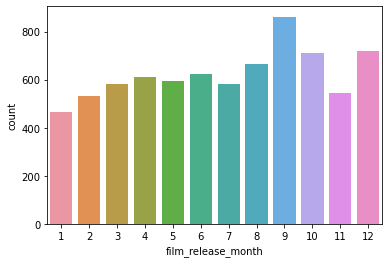

In [41]:
sns.countplot(x='film_release_month',data=train_data)

In [42]:
#It looks like the majority of films were release in September

<AxesSubplot:xlabel='film_release_day', ylabel='count'>

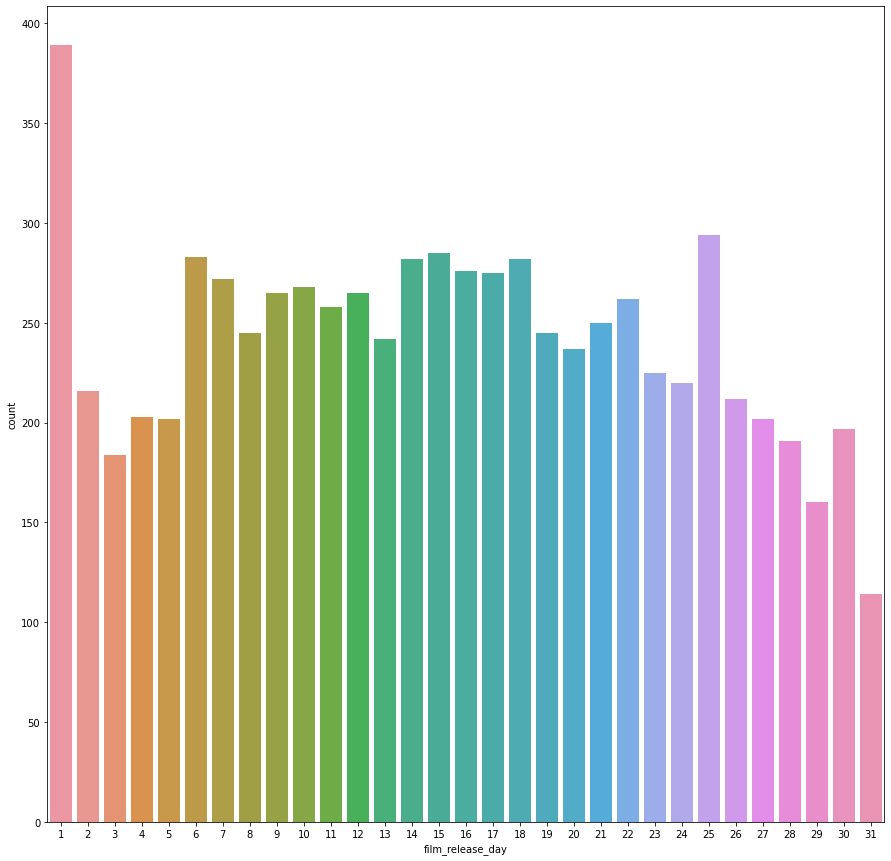

In [43]:
#Lets see about the beginning or ending of the month?
plt.figure(figsize=(15,15))
sns.countplot(x='film_release_day',data=train_data)

In [44]:
#the first day of each month is the most popular 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 [Text(0, 0, '1972'),
  Text(1, 0, '1973'),
  Text(2, 0, '1974'),
  Text(3, 0, '1975'),
  Text(4, 0, '1976'),
  Text(5, 0, '1977'),
  Text(6, 0, '1978'),
  Text(7, 0, '1979'),
  Text(8, 0, '1980'),
  Text(9, 0, '1981'),
  Text(10, 0, '1982'),
  Text(11, 0, '1983'),
  Text(12, 0, '1984'),
  Text(13, 0, '1985'),
  Text(14, 0, '1986'),
  Text(15, 0, '1987'),
  Text(16, 0, '1988'),
  Text(17, 0, '1989'),
  Text(18, 0, '1990'),
  Text(19, 0, '1991'),
  Text(20, 0, '1992'),
  Text(21, 0, '1993'),
  Text(22, 0, '1994'),
  Text(23, 0, '1995'),
  Text(24, 0, '1

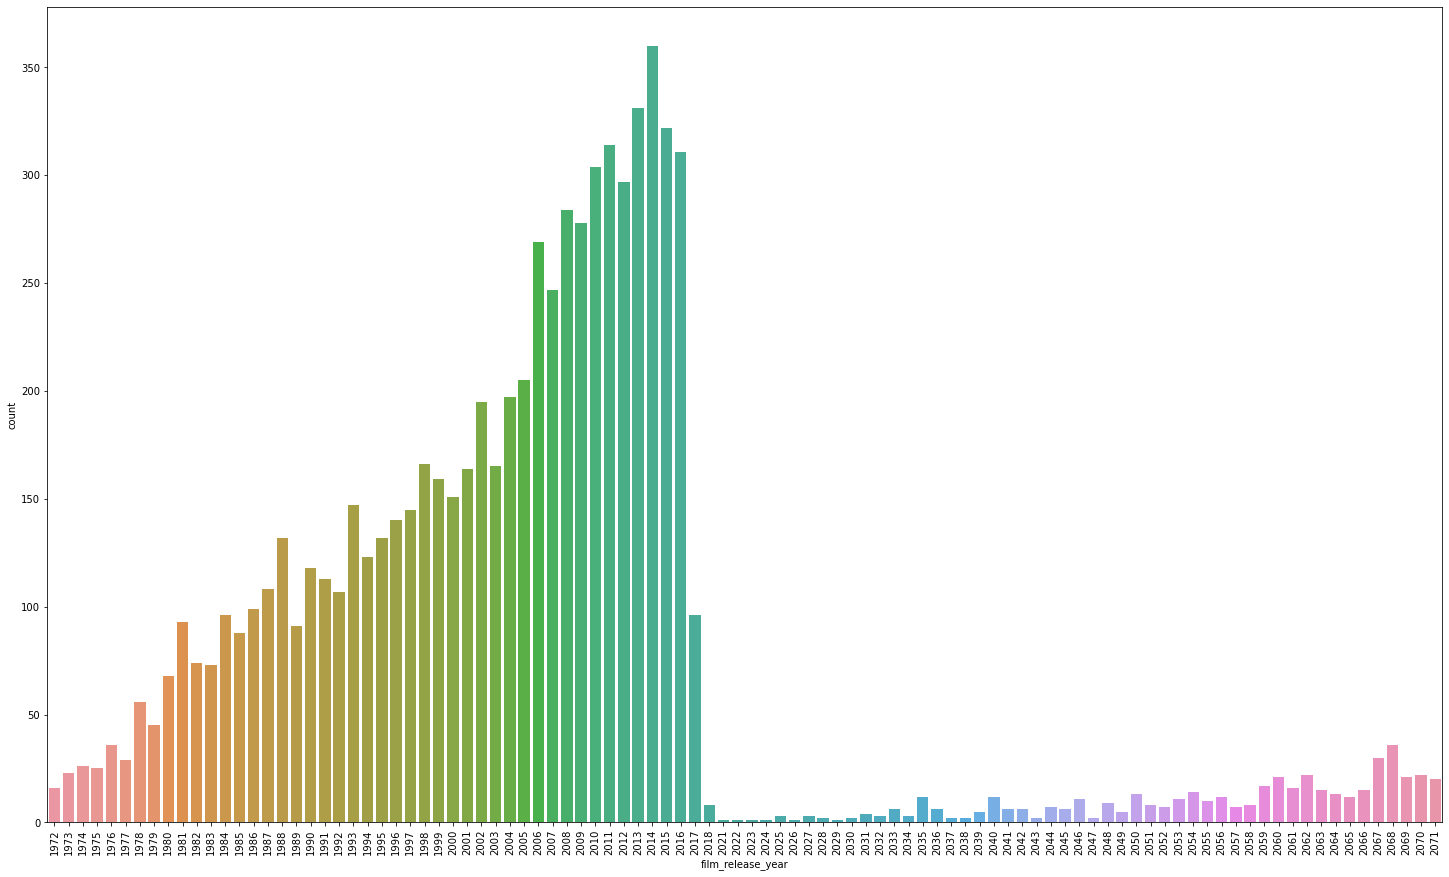

In [45]:
#release year popularity?
plt.figure(figsize=(25,15))
sns.countplot(x='film_release_year',data=train_data)
plt.xticks(rotation=90)

In [46]:
#We can see that something does not look right with the years

In [47]:
#fix it with 
train_data['film_release_year'] = train_data['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 [Text(0, 0, '1918'),
  Text(1, 0, '1921'),
  Text(2, 0, '1922'),
  Text(3, 0, '1923'),
  Text(4, 0, '1924'),
  Text(5, 0, '1925'),
  Text(6, 0, '1926'),
  Text(7, 0, '1927'),
  Text(8, 0, '1928'),
  Text(9, 0, '1929'),
  Text(10, 0, '1930'),
  Text(11, 0, '1931'),
  Text(12, 0, '1932'),
  Text(13, 0, '1933'),
  Text(14, 0, '1934'),
  Text(15, 0, '1935'),
  Text(16, 0, '1936'),
  Text(17, 0, '1937'),
  Text(18, 0, '1938'),
  Text(19, 0, '1939'),
  Text(20, 0, '1940'),
  Text(21, 0, '1941'),
  Text(22, 0, '1942'),
  Text(23, 0, '1943'),
  Text(24, 0, '1

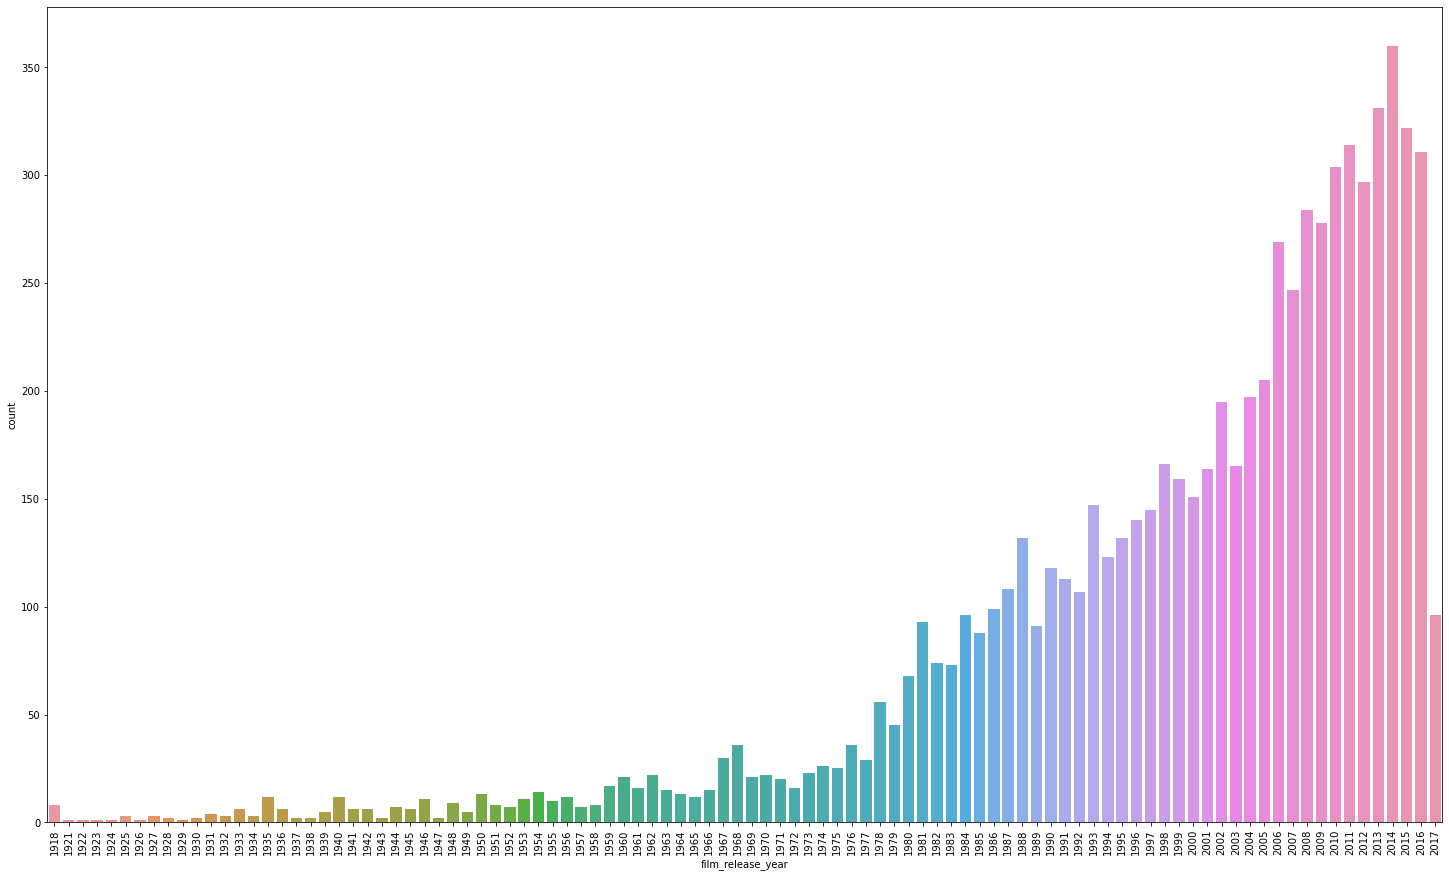

In [48]:
#make sure 
#release year popularity?
plt.figure(figsize=(25,15))
sns.countplot(x='film_release_year',data=train_data)
plt.xticks(rotation=90)

In [49]:
#fixed!

In [50]:
#2nd: Runtime
print(len(train_data[train_data['runtime']==0]))

3


In [51]:
#fixing thos 3 '0' values in the train_data

In [52]:
train_data['runtime'].replace(0, np.nan, inplace=True)

In [53]:
train_data.dropna(inplace=True)

In [54]:
#checking correlation between budget and the other features
import scipy.stats as stats
X = train_data[train_data['budget'] != 0]
for i in X.select_dtypes(include='number', exclude='datetime'):
    print(i, stats.pearsonr(X.budget, X[i]))

Unnamed: 0 (-0.008654569770200855, 0.4536782914547729)
id (0.013401639841375384, 0.24591857611718154)
budget (1.0, 0.0)
popularity (0.28257956976057774, 1.1290309795390754e-137)
runtime (0.1761643419724832, 2.5200777994843187e-53)
revenue (0.671982486940382, 0.0)
logrevenue (0.37095346257364115, 2.6242279526996e-243)
film_release_year (0.26316432916762145, 5.250553489423155e-119)
film_release_month (0.0165813384227688, 0.15110086045336807)
film_release_week (0.014939829498793925, 0.19583432490745978)
film_release_day (0.014466858409919753, 0.21036722109169692)


In [55]:
#strongest correlations
#popularity 
#film_release_year

In [56]:
train_data= train_data.drop(columns=['poster_path'])

In [57]:
#do the same thing we did for genre for production company, country
train_data["production_countries"] = train_data.production_countries.astype(str)
train_data["production_companies"] = train_data.production_companies.astype(str)

In [58]:
def proc_json(string, key):
    try:
        data = eval(string)
        return ",".join([d[key] for d in data])
    except:
        return ''
    
train_data.production_countries = train_data.production_countries.apply(lambda x: proc_json(x, 'name'))
train_data.production_companies = train_data.production_companies.apply(lambda x: proc_json(x, 'name'))

In [59]:
train_data['production_company'] = train_data['production_companies'].str.split(',').str[0]
train_data['production_country'] = train_data['production_countries'].str.split(',').str[0]


In [60]:
train_data= train_data.drop(columns=['production_companies','production_countries'])

In [61]:
train_data['production_company'].describe()

count                   7498
unique                  1931
top       Universal Pictures
freq                     445
Name: production_company, dtype: object

In [62]:
#Keep in mind that all the categorical variables are nominal so they will need to be 
#onehotencoded NOT Intenger Encoding

In [63]:
#import sklearn dependencies 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [64]:
train_data.head()

,Unnamed: 0,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,release_date,runtime,spoken_languages,status,title,cast,crew,revenue,logrevenue,film_release_year,film_release_month,film_release_week,film_release_day,production_company,production_country
0,0,1,1.400000e+07,Comedy,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651.0,16.326300,2015,2,8,20,Paramount Pictures,United States of America
1,1,2,4.000000e+07,"Comedy,Drama,Family,Romance",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,2004-08-06,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435.0,18.370959,2004,8,32,6,Walt Disney Pictures,United States of America
2,2,3,3.300000e+06,Drama,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000.0,16.387512,2014,10,41,10,Bold Films,United States of America
6,6,7,1.400000e+07,"Horror,Thriller",tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,2012-08-30,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Possession,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075.0,18.263396,2012,8,35,30,Ghost House Pictures,United States of America
8,8,9,3.216656e+07,"Action,Comedy,Music,Family,Adventure",tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,1996-02-16,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Muppet Treasure Island,"[{'cast_id': 1, 'character': 'Long John Silver...","[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391.0,17.351454,1996,2,7,16,Walt Disney Pictures,United States of America


In [65]:
my_code= train_data.copy()

# Converting Categorical Data to numeric with OneHotEncoding 
We need to convert:
- genre
- production company
- production country
- original language 

In [66]:
#creating numerical data for the genre column 
genre_column_names = []
for gen in genres:
    col_name = 'genre_' + gen.replace(' ', '_')
    train_data[col_name] = train_data.genres.str.contains(gen).astype('uint8')
    genre_column_names.append(col_name)

In [67]:
train_data = pd.get_dummies(train_data, columns = ["original_language"])
train_data = pd.get_dummies(train_data, columns = ["production_company"])
train_data = pd.get_dummies(train_data, columns = ["production_country"])
#train_data = pd.get_dummies(train_data, columns = ["production_company"])

In [68]:
#drop columns 
train_data= train_data.drop(columns=['genres','id','imdb_id','original_title','overview','status','title','cast',
                                     'crew','release_date','spoken_languages'])

In [69]:
train_data.reset_index(inplace=True)

In [70]:
print(train_data.shape)
train_data.head(5)

(7498, 2078)


index  Unnamed: 0        budget  popularity  runtime     revenue  \
0      0           0  1.400000e+07    6.575393     93.0  12314651.0   
1      1           1  4.000000e+07    8.248895    113.0  95149435.0   
2      2           2  3.300000e+06   64.299990    105.0  13092000.0   
3      6           6  1.400000e+07    7.286477     92.0  85446075.0   
4      8           8  3.216656e+07    6.902423    100.0  34327391.0   

   logrevenue  film_release_year  film_release_month  film_release_week  \
0   16.326300               2015                   2                  8   
1   18.370959               2004                   8                 32   
2   16.387512               2014                  10                 41   
3   18.263396               2012                   8                 35   
4   17.351454               1996                   2                  7   

   film_release_day  genre_Comedy  genre_Drama  genre_Family  genre_Romance  \
0                20             1            0             0              0   
1                 6             1            1             1              1   
2                10             0            1             0              0   
3                30             0            0             0              0   
4                16             1            0             1              0   

   genre_Horror  genre_Thriller  genre_Action  genre_Music  genre_Adventure  \
0             0               0             0            0                0   
1             0               0             0            0                0   
2             0               0             0            0                0   
3             1               1             0            0                0   
4             0               0             1            1                1   

   genre_Crime  genre_Science_Fiction  genre_Mystery  genre_Foreign  \
0            0                      0              0              0   
1            0                      0              0              0   
2            0                      0              0              0   
3            0                      0              0              0   
4            0                      0              0              0   

   genre_Animation  genre_Fantasy  genre_War  genre_Western  \
0                0              0          0              0   
1                0              0          0              0   
2                0              0          0              0   
3                0              0          0              0   
4                0              0          0              0   

   genre_Documentary  genre_History  genre_TV_Movie  original_language_af  \
0                  0              0               0                     0   
1                  0              0               0                     0   
2                  0              0               0                     0   
3                  0              0               0                     0   
4                  0              0               0                     0   

   original_language_ar  original_language_bm  original_language_bn  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   original_language_ca  original_language_cn  original_language_cs  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   original_language_da  original_language_de  origi

In [71]:
train_data= train_data.drop(columns=['logrevenue'])

In [72]:
train_data= train_data.drop(columns=['index'])

# Random Forest

hyperparameters include the number of decision trees in the forest and the number of features considered by each tree when splitting a node. (The parameters of a random forest are the variables and thresholds used to split each node learned during training). 

In [81]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [93]:
X = train_data.drop('revenue', axis=1).copy()
y = train_data['revenue'].copy()

In [94]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [95]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [96]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 43114211.33709334
Mean Squared Error: 7120763279764169.0
Root Mean Squared Error: 84384615.18407351


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

In [86]:
from sklearn.feature_selection import SelectFromModel

In [87]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)

NameError: name 'clf' is not defined

In [324]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

In [325]:
clf = LogisticRegression().fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.9998221273568125
Testing Score: 0.9984


In [326]:
clf = LogisticRegression()
clf.fit(X_selected_train_scaled, y_train)
print(f'Training Score: {clf.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_selected_test_scaled, y_test)}')

Training Score: 0.9996442547136251
Testing Score: 0.9984


# Building our Models

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [83]:
X = train_data.drop(['revenue'],axis=1).copy()
y = train_data['revenue'].copy()

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
print("Shape of X_train is : ",X_train.shape[0])
print("Shape of y_train is : ",y_train.shape[0])
print("Shape of X_test is : ",X_test.shape[0])
print("Shape of y_test is : ",y_test.shape[0])

Shape of X_train is :  5623
Shape of y_train is :  5623
Shape of X_test is :  1875
Shape of y_test is :  1875


In [84]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [85]:
lr_ = LinearRegression()
lr_.fit(X_train,y_train)
pred = lr_.predict(X_test)

/Users/meredithgray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


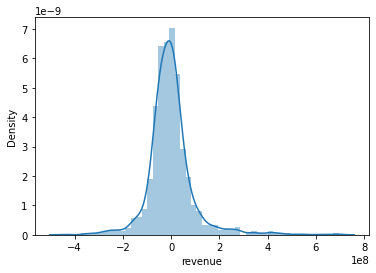

In [86]:
sns.distplot((y_test-pred),bins=50)
plt.show()

In [87]:
def rmsle(y_true, y_pred):
    return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [88]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
print('RMSLE:', rmsle(y_test, pred))

MAE: 60176746.36010314
MSE: 9015530786455142.0
RMSE: 94950148.95435995
RMSLE: ('rmsle', 2.7240772843946774, False)


<ipython-input-87-b98b27b53830>:2: RuntimeWarning: invalid value encountered in log1p
  return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


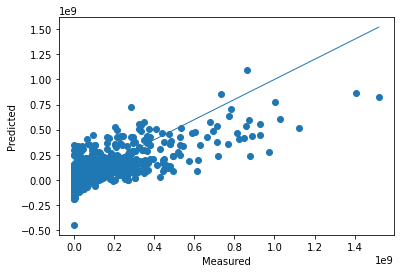

In [89]:
fig, ax = plt.subplots()
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


In [75]:
def test_model(model, data):
    X_train_scaled, X_test_scaled, y_train, y_test = data
    reg = model.fit(X_train_scaled, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train_scaled, y_train)}')
    print(f'Test Score: {reg.score(X_test_scaled, y_test)}\n')
    plt.show()    

In [76]:
# Create data
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
data = [X_train_scaled, X_test_scaled, y_train, y_test]

In [79]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [80]:
test_model(LinearRegression(), data)

test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)

Model: LinearRegression
Train score: -3.023859612942429
Test Score: -2.129690292029422e+27

Model: KNeighborsRegressor
Train score: 0.5884754676333728
Test Score: 0.342065954476482

Model: RandomForestRegressor
Train score: 0.9469027135744943
Test Score: 0.5798234181065118

Model: ExtraTreesRegressor
Train score: 0.99961205699409
Test Score: 0.5373297991971937

Model: AdaBoostRegressor
Train score: 0.44473952882869894
Test Score: 0.2446729164949626

Model: SVR
Train score: -0.1260092767981036
Test Score: -0.14941981560966755

